# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Targeted Podcast-Based Marketing on Reddit
#### by Benjamin Haile


## Problem Statement

Hardwire is a marketing firm specializing in gaming and online media. We want to tailor digital marketing to social media users based on the interests they express online. One avenue we’re pursuing is the design of an algorithm for understanding a user’s interests based on Reddit posts. We’re testing our algorithm on the audiences of two podcasts we’ve worked with before: the Rooster Teeth Podcast and Castle Super Beast. Both of these podcasts focus on video games, while also touching on different media. We expect some overlap in audiences between the two, but overall, these audiences have subcultures with different interests. To complete the algorithm, we need a classification model that will predict which podcast’s subreddit a user posts in based on the post’s title. The algorithm can then show a user relevant ads based on key words associated with that podcast.

I will first fit a logistic regression, and then fit different types of naive Bayes models if the original model requires more complexity. Models will be evaluated on accuracy, and variance and AUC will also be considered.


## Executive Summary

I used the Pushshift API to collect data on posts in the subreddit r/RoosterTeeth and r/TwoBestFriendsPlay (the former name of Castle Super Beast). I adjusted my function to draw a roughly equal amount of data of each subreddit. Preliminary data cleaning involved checking for null values and quantifying the names of the subreddits, for use in a classification model. I selected Rooster Teeth(RT) as 0 and Castle Super Beast(CSB) as 1. I chose the title of the post as my independent variable. This seemed to be the simplest choice, requiring less text to process. I filtered the data for unique values of 'title', to avoid overcounting any words. 

To explore the data, I created bar charts of the most common words in each subreddit, and between the two of them. This demonstrates the difference in audience interests. Understanding the unique interests of the podcasts' listeners is relevant given our ultimate goal of targeted marketing. I then fit a logistic regression model using 'title' to predict 'subreddit'. I also fit two naive Bayes models, a multinomial and a Gaussian, trying to reduce variance. The multinomial model proved to be the most accurate. This model is fit to complete our algorithm. Moving forward, we should also keep the differences in audience interest in mind when designing targeted marketing.

## Table of Contents
- [Loading Libraries & Data](#Loading-Libraries-&-Data)
- [EDA](#EDA)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [References](#References)

## Loading Libraries and Data

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
import sklearn.metrics as metrics
import nltk

%matplotlib inline

In [439]:
data = pd.read_csv('../project_3/subreddit_data')
data

,Unnamed: 0,title,subreddit
0,0,Hard and Soft canon,1
1,14,What are some games with good first-person mel...,1
2,18,How to Completely Retrain Yourself in Fighting...,1
3,22,What are some games you would love an in depth...,1
4,28,Star Wars Prequel Trilogy vs New Trilogy,1
...,...,...,...
2367,490,Thought I saw a RWBY reference in Doctor Sleep...,0
2368,492,Is there any way to find out who's in a specif...,0
2369,495,I speculate that #Teamtrees and all the donati...,0
2370,498,[No Spoliers] RWBY Posters in Doctor Sleep,0


In [440]:
data.drop(columns={'Unnamed: 0'}, inplace=True)
data.head()

,title,subreddit
0,Hard and Soft canon,1
1,What are some games with good first-person mel...,1
2,How to Completely Retrain Yourself in Fighting...,1
3,What are some games you would love an in depth...,1
4,Star Wars Prequel Trilogy vs New Trilogy,1


## EDA

In [441]:
rt = data[data['subreddit'] == 0]
csb = data[data['subreddit'] == 1]

### Average title length

In [442]:
csb.fillna('').astype(str).apply(lambda x:x.str.len()).mean() # from DYZ on StackOverflow

title        61.186747
subreddit     1.000000
dtype: float64

In [443]:
rt.fillna('').astype(str).apply(lambda x:x.str.len()).mean()

title        47.675207
subreddit     1.000000
dtype: float64

Above, I compare the average length of titles(in characters) for each subreddit. If they were too different, this could raise questions about the different ways the two groups interact with each other. As it is, I am not convinced that this difference is worth exploring further.

### Dropping duplicates

In [444]:
data.describe(include = 'object')

,title
count,2372
unique,2311
top,Off Topic Livestream Discussion Thread
freq,15


In [445]:
data.drop_duplicates(subset='title', inplace=True)
data.describe(include = 'object')

,title
count,2311
unique,2311
top,My Review of every Godzilla Universe Film cont...
freq,1


I dropped duplicates within the 'title' column to avoid overcounting words and throwing off the predictions.

### Examining the most common words

In [446]:
X = data['title']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = 'english')
X_train = cvec.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_df

,000,000 000,000 total,000 trees,00100000,00100000 01000011,00100000 01010100,00100000 01100110,00100000 01101001,00100001,...,در یخچال,شده,شده در,فریزر,فریزر های,های,های هیمالیا,هیمالیا,یخچال,یخچال فریزر
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Most Common Words Among Both Podcasts')

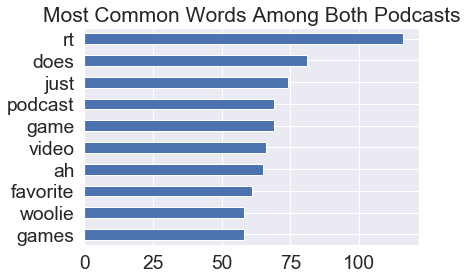

In [447]:
X_train_df.sum().sort_values(ascending = False).head(50) # Code help from Greg

top_words = (X_train_df.sum().sort_values(ascending = False).head(10))
top_words.sort_values(ascending=True).plot(kind = 'barh')
plt.title('Most Common Words Among Both Podcasts')

Common words among both include variations of the podcasts' titles and names of the hosts. I may exlclude these from the modeling by adding them to the list of stop words.

In [448]:
X = csb['title']
y = csb['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = 'english')
X_train = cvec.fit_transform(X_train)
X_train_df1 = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_df1

X_train_df1.sum().sort_values(ascending = False).head(50)

woolie        58
favorite      57
game          54
games         49
pat           46
just          42
like          41
does          41
media         37
character     35
podcast       33
think         30
know          29
best          26
spoilers      26
talk          25
dmc           24
characters    23
people        23
video         23
thing         21
series        20
good          20
actually      19
time          18
new           18
play          18
dmc5          18
smash         17
make          16
got           16
ve            15
playing       15
dmcv          15
times         15
guys          15
really        15
shit          15
don           15
did           15
fighting      14
devil         14
help          13
super         13
feel          13
better        13
lp            12
music         12
great         12
worst         12
dtype: int64

Text(0.5, 1.0, 'Most Common Words: Castle Super Beast')

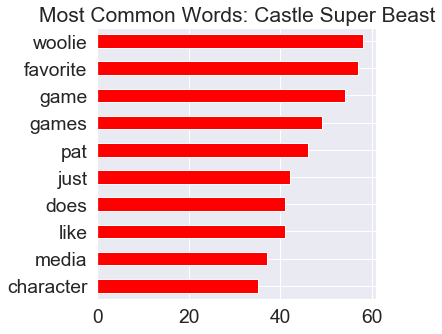

In [449]:
top_csb = (X_train_df1.sum().sort_values(ascending = False).head(10))
plt.figure(figsize=(5,5))
top_csb.sort_values(ascending=True).plot(kind = 'barh', color='red')
plt.title('Most Common Words: Castle Super Beast')

Despite having some similarities, this podcast is the only one whose top 50 words feature actual video games, in this case, Devil May Cry 5 and Super Smash Brothers Ultimate.

In [450]:
X = rt['title']
y = rt['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

cvec = CountVectorizer(ngram_range = (1,2),
                       stop_words = 'english')
X_train = cvec.fit_transform(X_train)
X_train_df0 = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())
X_train_df0

X_train_df0.sum().sort_values(ascending = False).head(50)

rt                       128
ah                        59
life                      57
extra life                55
extra                     55
podcast                   53
rooster                   44
rooster teeth             43
teeth                     43
video                     43
does                      37
just                      35
did                       34
videos                    30
thread                    29
new                       28
site                      27
app                       25
play                      25
achievement               25
game                      25
rt podcast                25
question                  25
content                   24
live                      23
episode                   23
rtx                       23
know                      23
topic                     22
roosterteeth              22
livestream                21
hunter                    21
discussion                21
achievement hunter        20
let           

Text(0.5, 1.0, 'Most Common Words: Rooster Teeth')

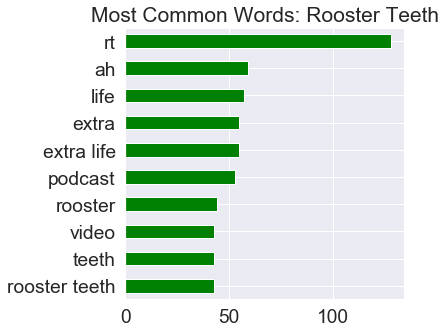

In [451]:
top_rt = (X_train_df0.sum().sort_values(ascending = False).head(10))
plt.figure(figsize=(5,5))
top_rt.sort_values(ascending=True).plot(kind = 'barh', color='green')
plt.title('Most Common Words: Rooster Teeth')

This subreddit is clearly focused on various RT projects. The only specific reference to gaming is 'xbox'.

There is a clear separation of interests between theses two subreddits. We must keep this in mind when presenting ads to each audience.

## Model Preparation

In [452]:
X = data['title']
y = data['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)

In [453]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(['TwoBestFriendsPlay', 'Castle Super Beast', 'CSB', 'woolie', 'pat', 
                  'Rooster Teeth', 'rooster teeth', 'RT', 'rooster', 'teeth', 'geoff'])

I have added the podcasts' titles and some common variations to the stop words. I have also added the most commonly occurring names of the hosts. It may be too obvious to predict a subreddit based on its title. This way, I intend to base predictions on words that the audiences may be more specifically interested in. These words were discovered during the EDA. Because they are very common, I want to be careful of their influence on the model.

## Modeling

### Baseline Model

In [454]:
y_test.value_counts(normalize=True)

0    0.546713
1    0.453287
Name: subreddit, dtype: float64

The baseline score is 55% in favor of Rooster Teeth. Any acceptable model will need an accuracy score higher than this.

### Logistic Regression Model

In [455]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [2, 5],
    'cvec__max_df': [0.1,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english']
}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)

gs.fit(X_train, y_train)
gs_model = gs.best_estimator_
print(gs_model.score(X_train, y_train))
print(gs_model.score(X_test, y_test))
print(cross_val_score(gs_model, X_train, y_train, cv=5).mean())

0.9549913444893249
0.8529411764705882
0.84821342306475


In [456]:
gs.best_params_

{'cvec__max_df': 0.1,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

This model seems to have good accuracy, but I want to see if I can decrease the variance.

### 2nd Logistic Regression Model

In [457]:
# LogReg 2
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'cvec__max_features': [900, 1000, 1500],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english', None]}

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5)
gs.fit(X_train, y_train)
gs.best_params_
gs_model = gs.best_estimator_
print(gs_model.score(X_train, y_train))
print(gs_model.score(X_test, y_test))
print(cross_val_score(gs_model, X_train, y_train, cv=5).mean())

0.953260242354299
0.8512110726643599
0.84821342306475


In [458]:
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

Making several adjustments to the logistic regression model has not affected the model's performance by much. I will now fit two naive Bayes models, to see if their additional complexity can make a more accurate model.

### Naive Bayes: Multinomial

In [459]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mn', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [None, 500, 1000, 5000],
    'cvec__min_df': [2, 5],
    'cvec__max_df': [0.1,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english']
}

gsm = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5)

In [460]:
gsm.fit(X_train, y_train)
gsm.best_params_
gsm_model = gsm.best_estimator_
print(gsm_model.score(X_train, y_train))
print(gsm_model.score(X_test, y_test))
print(cross_val_score(gsm_model, X_train, y_train, cv=5).mean())

0.9284477784189267
0.8512110726643599
0.854565141343639


In [461]:
gsm.best_params_

{'cvec__max_df': 0.1,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

This model has good accuracy and the variance is less than that of the first model.

### Naive Bayes: Gaussian

In [462]:
pipe = Pipeline(steps = [  # Code from Danny
    ('feats', FeatureUnion([ 
        ('cvec', CountVectorizer()),
    ])),
    ('trans',  FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),     
    ("model",  GaussianNB()),
]) 

pipe_params = {
    'feats__cvec__max_features': [None, 500, 1000, 5000],
    'feats__cvec__min_df': [2, 5],
    'feats__cvec__max_df': [0.1,.9, .95],
    'feats__cvec__ngram_range': [(1,1), (1,2)],
    'feats__cvec__stop_words': [None, 'english']
}
gsg = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5)

In [463]:
gsg.fit(X_train, y_train)
gsg.best_params_
gsg_model = gsg.best_estimator_
print(gsg_model.score(X_train, y_train))
print(gsg_model.score(X_test, y_test))

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

0.9399884593190998
0.8166089965397924


/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [464]:
print(cross_val_score(gsg_model, X_train, y_train, cv=5).mean())

/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/pr

0.8164864819843081


/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/Users/user/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


The Gaussian model has the largest variance of all of the models seen so far.

## Model Selection

The multinomial model is the most accurate. It is very similar in accuracy to the first logistic regression model, but the difference between the training score and the test score is smaller, meaning that the multinomial model is the least overfit.

## Model Evaluation

### Double-checking the accuracy score: 85%

In [465]:
y_pred_mn = gsm.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_mn))

0.8512110726643599


### Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

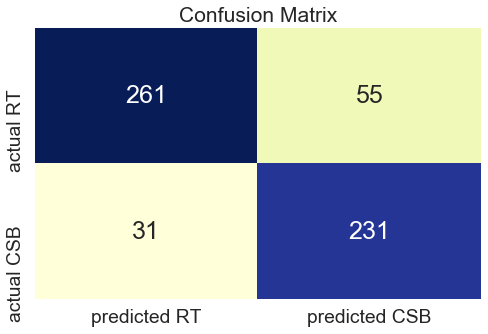

In [466]:
cm = confusion_matrix(y_test, y_pred_mn)
cm_df = pd.DataFrame(cm, columns=['predicted RT', 'predicted CSB'], index=['actual RT', 'actual CSB'])

plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={"size": 25}, cbar=False, cmap="YlGnBu")
sns.set(font_scale=1.75)
plt.title('Confusion Matrix')

This confusion matrix confirms that, overall, this model accurately predicts which post comes from which subreddit. There are some visible false predictions. For our purposes, this is not necessarily a problem. Given the similar premises of these podcasts, the fanbases are likely to overlap. Even as we tailor marketing to unique audiences, we should remember that some users are open to both. There are fewer of this type of user, so pursuing them should not overtake our original goal.

### ROC Curve

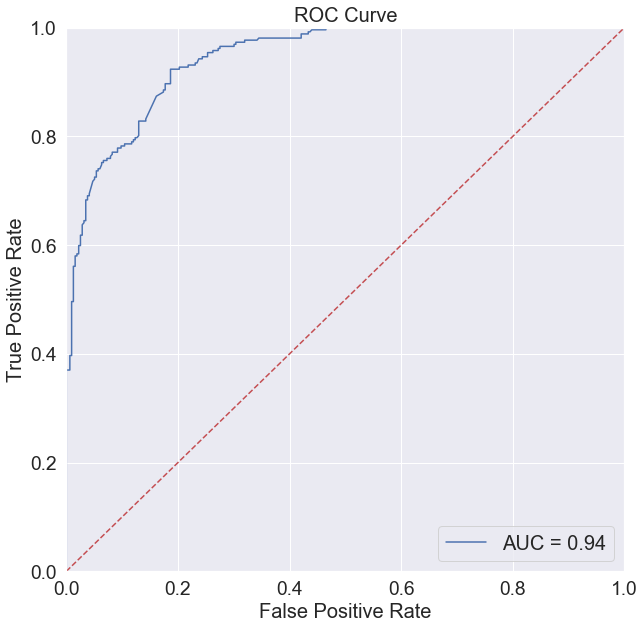

In [467]:
probs = gsm.predict_proba(X_test) # Via StackOverflow
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=20)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.show()

The AUC score is very close to 1, meaning that our model successfully separates the two classes.

## Conclusion and Recommendations

Our model makes accurate predictions, and is ready to be added to our larger algorithm. Using this algorithm will predict which podcast a user prefers based on their Reddit posts and tailor the ads they see accordingly. CSB listeners are much more likely to post about video games specifically, so their ads should be for other games. They seem especially interested in games from Capcom(developers of Devil May Cry) and Nintendo(developers of SSBU). Rooster Teeth fans, conversely, post mostly about RT media, rather than specific games. Their ads should be for content made by similar production companies. Moving forward, we can apply this algorithm to the subreddits of other podcasts to reach more audiences. We can also start developing targeted marketing based on how audiences use YouTube and Twitch.

## References

[Rooster Teeth subreddit](https://www.reddit.com/r/roosterteeth/)

[Castle Super Beast subreddit](https://www.reddit.com/r/TwoBestFriendsPlay/)